# Introduction

 **Particle identification**: training a classifier to detect electrons, protons, muons, kaons and pions


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import xgboost as xg
import tables as tb
from tqdm import tqdm
from itertools import cycle, islice
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import make_blobs
from IPython import display
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import log_loss
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
import utils

%matplotlib inline
%pylab inline

# Make the images larger
plt.rcParams['figure.figsize'] = (16, 9)
figsize = (10,10)
point_size=150
point_border=0.8

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib
['dark-matter-from-opera-experiments', 'particle-identification']


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Particle Identification

In [ ]:
training = pd.read_csv('../input/particle-identification/training.csv')
test = pd.read_csv('../input/particle-identification/test.csv')

In [ ]:
training.shape

(1200000, 50)

In [ ]:
test.shape

(1200000, 50)

In [ ]:
training.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,Label,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,17.585680,1.0,-6.411697,-7.213295,0.000001,1.467550,-26.667494,-2.730674,1.0,-5.152923,1.0,-999.000000,19.954819,3141.930677,0.613640,1.0,-0.909544,-999.000000,1.0,-0.661823,4.0,1.0,1.0,0.018913,5.366212,Muon,-21.913000,1.0,1.0,1.015345,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,20.230680,1.0,5.453014,0.000006,1531.542000,3.570540,-0.711194,1.773806,1.0,-999.000000,0.0,33.187644,0.037601,199.573653,0.465480,1.0,0.434909,13.667366,1.0,-999.000000,10.0,0.0,0.0,0.351206,9.144749,Ghost,-0.703617,0.0,1.0,-2.394644,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,11.619878,0.0,-999.000000,-999.000000,-999.000000,0.826442,-999.000000,-999.000000,0.0,-999.000000,0.0,-999.000000,-999.000000,94.829418,0.241891,0.0,-999.000000,-999.000000,0.0,-999.000000,5.0,0.0,0.0,0.195717,1.459992,Ghost,-999.000000,0.0,0.0,-999.000000,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,15.336305,1.0,-10.616585,-39.447507,4385.688000,1.076721,-29.291509,-3.053104,1.0,-999.000000,1.0,231.190351,2.839508,808.631064,0.680705,1.0,-1.504160,1939.259641,1.0,-999.000000,9.0,0.0,1.0,0.003972,22.950573,Pion,-47.223118,1.0,1.0,-0.321242,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,10.954629,1.0,-8.144945,26.050386,1220.930044,0.439767,21.386587,-2.730648,1.0,-999.000000,1.0,-794.866475,1.209193,1422.569214,0.575066,1.0,-1.576249,1867.165142,1.0,-999.000000,5.0,0.0,0.0,0.015232,3.516173,Proton,15.304688,0.0,1.0,-1.038026,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


In [ ]:
test.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton,ID
0,55086.199233,18.0,-0.438763,0.0,1.0,3.2,-1.843821,-4.579244,1.0,-1.732886,22.757613,1.0,-6.392882,16.911903,4416.383799,1.176239,37.200702,-2.321282,1.0,-999.000000,1.0,170.771073,0.328454,1732.758804,0.678807,1.0,-1.409228,3431.213151,1.0,-999.000000,7.0,0.0,1.0,0.004411,6.541830,22.749886,1.0,1.0,-1.790535,34.0,1.0,18.674086,-1.355015,24510.990244,0.0,1.0,9.325265,-0.250015,35.408585,0
1,3393.820071,17.0,-0.554341,0.0,1.0,0.0,-0.883237,-6.203035,1.0,-0.097206,21.951430,1.0,-6.867096,15.577288,0.000007,3.497992,11.866988,-2.460519,1.0,-999.000000,1.0,542.144654,20.769733,261.281253,0.170659,1.0,-0.600473,726.542115,1.0,-999.000000,8.0,0.0,0.0,0.046897,8.506494,11.725304,0.0,1.0,-0.289500,34.0,1.0,16.536804,-17.601196,778.675303,0.0,1.0,-0.000006,-6.646096,14.011904,1
2,18341.359361,12.0,-0.554339,0.0,1.0,0.0,-2.653786,-3.922639,1.0,0.936484,7.882976,1.0,-8.499948,0.000006,-0.000002,0.752767,-4.892094,-2.805346,1.0,-999.000000,1.0,6090.963363,37.769978,681.985887,0.485022,1.0,-1.926941,4777.214828,1.0,-999.000000,7.0,1.0,1.0,0.002792,9.069770,-1.835909,1.0,1.0,-1.441898,30.0,1.0,-1.306109,-4.536409,7915.212420,0.0,1.0,1.371346,-2.132609,-5.617409,2
3,27486.710933,7.0,-0.492411,1.0,1.0,3.2,-999.000000,2.034453,1.0,-999.000000,13.373016,1.0,0.322580,-2.280805,-999.000000,1.438089,-8.657205,-0.075777,1.0,-0.476107,0.0,-999.000000,-999.000000,1267.466426,0.277881,1.0,-999.000000,-999.000000,0.0,-0.018407,6.0,1.0,1.0,0.003242,8.600039,1.848607,1.0,1.0,-999.000000,21.0,1.0,-4.222793,3.149207,-999.000000,1.0,1.0,61.985428,0.946207,-8.657193,3
4,6842.249996,16.0,0.098706,0.0,1.0,3.2,2.644499,-1.471364,1.0,-2.909470,18.442923,1.0,1.970983,-3.425082,2965.656006,0.866863,-5.322182,-3.011893,1.0,-999.000000,1.0,657.940203,1.674208,232.944958,2.554630,1.0,0.596886,17.644837,1.0,-999.000000,4.0,0.0,0.0,0.006850,2.285350,-6.326513,0.0,1.0,-2.463674,29.0,1.0,-3.425113,23.147387,-0.000013,0.0,1.0,2.468453,2.614987,-5.713513,4


From the dataset description, we know that the features describe particle responses in the detector systems, and represent the following:

- ID - id value for tracks (presents only in the test file for the submitting purposes)
- Label - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost". This column is absent in the test file.
- FlagSpd - flag (0 or 1), if reconstructed track passes through Spd
- FlagPrs - flag (0 or 1), if reconstructed track passes through Prs
- FlagBrem - flag (0 or 1), if reconstructed track passes through Brem
- FlagEcal - flag (0 or 1), if reconstructed track passes through Ecal
- FlagHcal - flag (0 or 1), if reconstructed track passes through Hcal
- FlagRICH1 - flag (0 or 1), if reconstructed track passes through the first RICH detector
- FlagRICH2 - flag (0 or 1), if reconstructed track passes through the second RICH detector
- FlagMuon - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
- SpdE - energy deposit associated to the track in the Spd
- PrsE - energy deposit associated to the track in the Prs
- EcalE - energy deposit associated to the track in the Hcal
- HcalE - energy deposit associated to the track in the Hcal
- PrsDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Prs
- BremDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Brem
- TrackP - particle momentum
- TrackPt - particle transverse momentum
- TrackNDoFSubdetector1  - number of degrees of freedom for track fit using hits in the tracking sub-detector1
- TrackQualitySubdetector1 - chi2 quality of the track fit using hits in the tracking sub-detector1
- TrackNDoFSubdetector2 - number of degrees of freedom for track fit using hits in the tracking sub-detector2
- TrackQualitySubdetector2 - chi2 quality of the track fit using hits in the  tracking sub-detector2
- TrackNDoF - number of degrees of freedom for track fit using hits in all tracking sub-detectors
- TrackQualityPerNDoF - chi2 quality of the track fit per degree of freedom
- TrackDistanceToZ - distance between track and z-axis (beam axis)
- Calo2dFitQuality - quality of the 2d fit of the clusters in the calorimeter 
- Calo3dFitQuality - quality of the 3d fit in the calorimeter with assumption that particle was electron
- EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
- EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
- EcalShowerLongitudinalParameter - longitudinal parameter of Ecal shower
- HcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Hcal
- HcalDLLbeMuon - delta log-likelihood for a particle candidate to be using information from Hcal
- RICHpFlagElectron - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
- RICHpFlagProton - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
- RICHpFlagPion - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
- RICHpFlagKaon - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
- RICHpFlagMuon - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
- RICH_DLLbeBCK  - delta log-likelihood for a particle candidate to be background using information from RICH
- RICH_DLLbeKaon - delta log-likelihood for a particle candidate to be kaon using information from RICH
- RICH_DLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from RICH
- RICH_DLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from RICH
- RICH_DLLbeProton - delta log-likelihood for a particle candidate to be proton using information from RICH
- MuonFlag - muon flag (is this track muon) which is determined from muon stations
- MuonLooseFlag muon flag (is this track muon) which is determined from muon stations using looser criteria
- MuonLLbeBCK - log-likelihood for a particle candidate to be not muon using information from muon stations
- MuonLLbeMuon - log-likelihood for a particle candidate to be muon using information from muon stations
- DLLelectron - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
- DLLmuon - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
- DLLkaon - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
- DLLproton - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
- GhostProbability - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.

Spd stands for Scintillating Pad Detector, Prs - Preshower, Ecal - electromagnetic calorimeter, Hcal - hadronic calorimeter, Brem denotes traces of the particles that were deflected by detector.

In [ ]:
def my_percentile(arr, w, q):
    left = 0.
    right = (w).sum()
    sort_inds = np.argsort(arr, axis=0)
    if left/right >= q/100.:
        return arr[0]
    for i in sort_inds:
        left += w[i]
        if left/right >= q/100.:
            return arr[i]

def plot(prediction, spectator, cut, percentile=True, weights=None, n_bins=100,
              color='b', marker='o', ms=4, label="MVA", fmt='o', markeredgecolor='b', markeredgewidth=2, ecolor='b'):
    if weights is None:
        weights = np.ones(len(prediction))

    if percentile:
        if weights is None:
            cut = np.percentile(prediction, 100-cut)
        else:
            cut = my_percentile(prediction, weights, 100-cut)
    
    edges = np.linspace(spectator.min(), spectator.max(), n_bins)
    
    xx = []
    yy = []
    xx_err = []
    yy_err = []
    
    for i_edge in range(len(edges)-1):

        left = edges[i_edge]
        right = edges[i_edge + 1]
        
        N_tot_bin = weights[((spectator >= left) * (spectator < right))].sum()
        N_cut_bin = weights[((spectator >= left) * (spectator < right) * (prediction >= cut))].sum()
        
        if N_tot_bin != 0:
            
            x = 0.5 * (right + left)
            y = 1. * N_cut_bin / N_tot_bin
            
            if y > 1.:
                y = 1.
            if y < 0:
                y = 0
            
            xx.append(x)
            yy.append(y)
            
            x_err = 0.5 * (right - left)
            y_err = np.sqrt(y*(1-y)/N_tot_bin)
            
            xx_err.append(x_err)
            yy_err.append(y_err)
        
        else:
            pass

    plt.errorbar(xx, yy, yerr=yy_err, xerr=xx_err, fmt=fmt, color=color, marker=marker, ms=ms, label=label, markeredgecolor=markeredgecolor, markeredgewidth=markeredgewidth, ecolor=ecolor)
    
    return cut

## Explore the dataset

In [ ]:
training['Label'].value_counts()

Electron    200000
Proton      200000
Ghost       200000
Pion        200000
Kaon        200000
Muon        200000
Name: Label, dtype: int64

## Train an AdaBoost model 

In [ ]:
# Get numeric labels for each of the string labels, to make them compatible with our model
label_class_correspondence = {'Electron': 0, 'Ghost': 1, 'Kaon': 2, 'Muon': 3, 'Pion': 4, 'Proton': 5}
class_label_correspondence = {0: 'Electron', 1: 'Ghost', 2: 'Kaon', 3: 'Muon', 4: 'Pion', 5: 'Proton'}

def get_class_ids(labels):
    return np.array([label_class_correspondence[alabel] for alabel in labels])

In [ ]:
training['Class'] = get_class_ids(training.Label.values)

Since we're trying to predict the label (or class), we remove them from our list of features.

In [ ]:
features = list(set(training.columns) - {'Label', 'Class'})

Split the training data into training and validation sets.

In [ ]:
train, valid = train_test_split(training, random_state=42, train_size=0.90, test_size=0.10)
print(train.shape[0], valid.shape[0])

1080000 120000


In [ ]:
train.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,Label,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton,Class
1132259,2789.090091,16.0,-0.416873,0.0,1.0,3.2,-1.698809,-10.603913,1.0,-1.846511,16.974368,1.0,-2.657101,-0.755913,1552.238040,3.869846,-0.000013,-2.460515,1.0,-999.000000,1.0,396.145856,0.169271,194.205417,0.880376,1.0,0.118092,1208.439587,1.0,-999.000000,8.0,0.0,0.0,0.379132,10.020974,Ghost,-1.067800,0.0,1.0,-2.365099,32.0,1.0,-0.299200,4.762200,-0.000017,0.0,1.0,1.919900,-7.032100,-6.824109e-08,1
498232,26449.490228,16.0,-0.205087,1.0,1.0,3.2,-2.730180,4.641538,1.0,0.689572,12.065813,1.0,-6.970032,-26.308816,-0.000013,0.906950,-6.497516,-2.835475,1.0,-3.867102,1.0,2226.406977,10.155994,1987.066278,0.664832,1.0,-0.786616,3689.072993,1.0,-0.577902,5.0,1.0,1.0,0.012628,3.781972,Muon,-8.603721,1.0,1.0,0.612602,30.0,1.0,-22.977721,-0.379422,2217.402586,1.0,1.0,0.000011,0.523978,-5.799722e+00,3
126444,2277.050045,12.0,-0.338936,0.0,1.0,0.0,-0.364495,-6.585461,1.0,0.389723,19.258255,1.0,-0.671509,0.000012,327.240009,1.400002,0.000012,-2.730661,1.0,-999.000000,1.0,-262.614923,9.122075,308.836513,0.158882,0.0,0.434908,519.516547,1.0,-999.000000,9.0,0.0,0.0,0.289728,9.820674,Ghost,0.000006,0.0,1.0,-2.463670,27.0,1.0,0.000006,16.390705,-0.000008,0.0,1.0,0.000003,-6.136794,5.668626e-06,1
315327,9996.969714,18.0,-0.621389,1.0,1.0,0.0,-2.550788,5.745645,1.0,-1.285639,6.720689,1.0,-9.101069,-62.479887,1790.676030,0.421431,-77.407389,-3.327996,1.0,-4.392384,1.0,135.321883,0.623957,1151.781847,0.088321,1.0,-1.059676,2029.181029,1.0,-1.000184,11.0,0.0,1.0,0.003522,5.128390,Muon,-58.982205,0.0,1.0,0.749060,37.0,1.0,-62.479905,-9.053305,2525.748519,1.0,1.0,3.839802,1.844695,-7.740741e+01,3
1059423,15853.089843,18.0,-999.000000,0.0,1.0,3.2,-1.611680,-1.165609,1.0,0.656944,9.721197,1.0,-6.197011,6.115595,-0.000017,0.598681,7.690195,-3.036344,0.0,-999.000000,1.0,3278.832524,56.587841,343.592437,0.464681,1.0,-1.394112,859.781010,1.0,-999.000000,2.0,0.0,1.0,0.065716,2.101380,Kaon,8.697807,1.0,0.0,-2.493681,24.0,1.0,6.462007,0.876007,16523.523441,0.0,1.0,2.468448,1.029407,8.243607e+00,2


In [ ]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=42,
                             base_estimator=DecisionTreeClassifier(max_depth=6, min_samples_leaf=30, random_state=42))
clf.fit(train[features].values, train.Class.values)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=42)

In [ ]:
proba_clf = clf.predict_proba(valid[features].values)
log_loss(valid.Class.values, proba_clf)

0.8077308638288425

In [ ]:
def roc_curves(predictions, labels):
    plt.figure(figsize=(9, 6))
    u_labels = np.unique(labels)
    for lab in u_labels:
        y_true = labels == lab
        y_pred = predictions[:, lab]
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        plt.plot(tpr, 1-fpr, linewidth=3, label=class_label_correspondence[lab] + ', AUC = ' + str(np.round(auc, 4)))
        plt.xlabel('Signal efficiency (TPR)', size=15)
        plt.ylabel("Background rejection (1 - FPR)", size=15)
        plt.xticks(size=15)
        plt.yticks(size=15)
        plt.xlim(0., 1)
        plt.ylim(0., 1)
        plt.legend(loc='lower left', fontsize=15)
        plt.title('One particle vs rest ROC curves', loc='right', size=15)
        plt.grid(b=1)

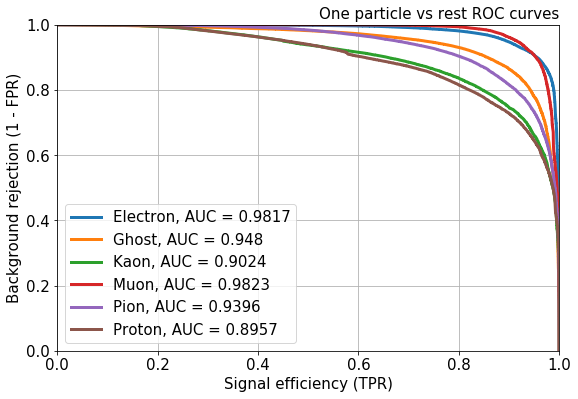

In [ ]:
roc_curves(proba_clf, valid.Class.values)

In [ ]:
def efficiency(predictions, labels, spectator, eff=60, n_bins=20, xlabel='Spectator'):
    plt.figure(figsize=(5.5*2, 3.5*3))
    u_labels = np.unique(labels)
    for lab in u_labels:
        y_true = labels == lab
        pred = predictions[y_true, lab]
        spec = spectator[y_true]
        plt.subplot(3, 2, lab+1)
        plot(pred, spec, cut=eff, percentile=True, weights=None, n_bins=n_bins, color='1', marker='o', 
                  ms=7, label=class_label_correspondence[lab], fmt='o')
        
        plt.plot([spec.min(), spec.max()], [eff / 100., eff / 100.], label='Global signal efficiecny', color='r', linewidth=3)
        plt.legend(loc='best', fontsize=12)
        plt.xticks(size=12)
        plt.yticks(size=12)
        plt.ylabel('Signal efficiency (TPR)', size=12)
        plt.xlabel(xlabel,size=12)
        plt.ylim(0, 1)
        plt.xlim(spec.min(), spec.max())
        plt.grid(b=1)
    plt.tight_layout()
        

def efficiency_on_p(predictions, labels, spectator, eff=60, n_bins=20):
    sel = spectator < 200 * 10**3
    efficiency(predictions[sel], labels[sel], spectator[sel] / 10**3, eff, n_bins, 'Momentum, GeV/c')

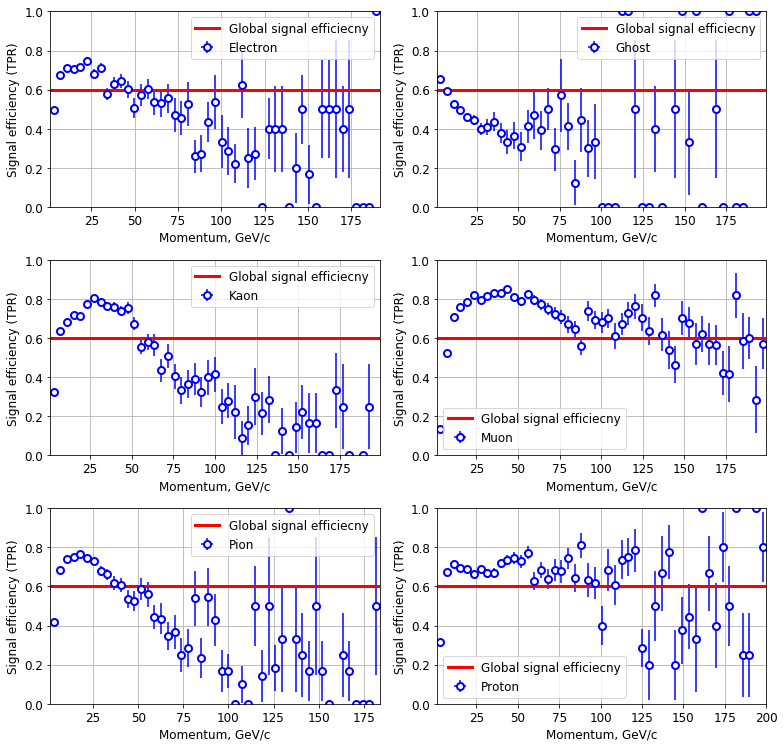

In [ ]:
efficiency_on_p(proba_clf, valid.Class.values, valid.TrackP.values, 60, 50)
plt.show()

In [ ]:
def efficiency_on_pt(predictions, labels, spectator, eff=60, n_bins=20):
    sel = spectator < 10 * 10**3
    efficiency(predictions[sel], labels[sel], spectator[sel] / 10**3, eff, n_bins, 'Transverse momentum, GeV/c')

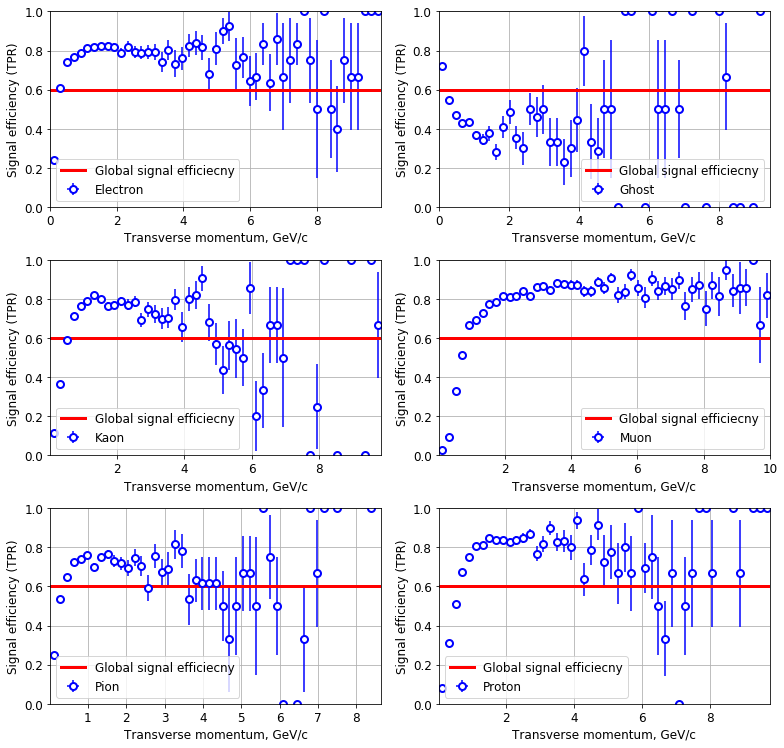

In [ ]:
efficiency_on_pt(proba_clf, valid.Class.values, valid.TrackPt.values, 60, 50)
plt.show()

## Train a Neural Network

Training a second, neural network model and comparing performance via ROC curves

In [ ]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim))
    model.add(Activation('tanh'))

    model.add(Dense(6))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    return model

In [ ]:
nn = nn_model(len(features))
nn.fit(train[features].values, np_utils.to_categorical(train.Class.values), verbose=1, nb_epoch=5, batch_size=256)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/5
1080000/1080000 [==============================] - 18s 16us/step - loss: 1.3389
Epoch 2/5
1080000/1080000 [==============================] - 14s 13us/step - loss: 1.1980
Epoch 3/5
1080000/1080000 [==============================] - 15s 14us/step - loss: 1.1236
Epoch 4/5
1080000/1080000 [==============================] - 15s 14us/step - loss: 1.0942
Epoch 5/5
1080000/1080000 [==============================] - 14s 13us/step - loss: 1.0697


In [ ]:
proba_nn = nn.predict_proba(valid[features].values)
log_loss(valid.Class.values, proba_nn)

1.054011837745396

In [ ]:
proba_nn

array([[1.0687001e-01, 1.1076091e-01, 5.2658036e-02, 4.4145751e-01,
        2.2905453e-01, 5.9198979e-02],
       [3.6576064e-03, 4.7586775e-01, 1.9981271e-01, 2.2277301e-02,
        1.1981156e-01, 1.7857313e-01],
       [8.8218495e-02, 3.3546263e-01, 8.2702383e-02, 1.4062624e-01,
        2.6219365e-01, 9.0796590e-02],
       ...,
       [3.3262151e-03, 1.7145225e-01, 8.4974825e-02, 3.0366825e-02,
        6.2619686e-01, 8.3683029e-02],
       [2.5428442e-04, 2.3887467e-02, 7.3862514e-03, 9.3624020e-01,
        2.6143577e-02, 6.0882545e-03],
       [1.0687001e-01, 1.1076091e-01, 5.2658036e-02, 4.4145751e-01,
        2.2905453e-01, 5.9198979e-02]], dtype=float32)

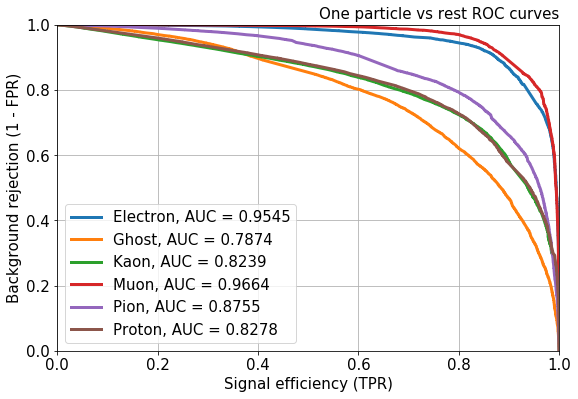

In [ ]:
roc_curves(proba_nn, valid.Class.values)

Just to compare performances, here are the ROC curves for our AdaBoostClassifier model.

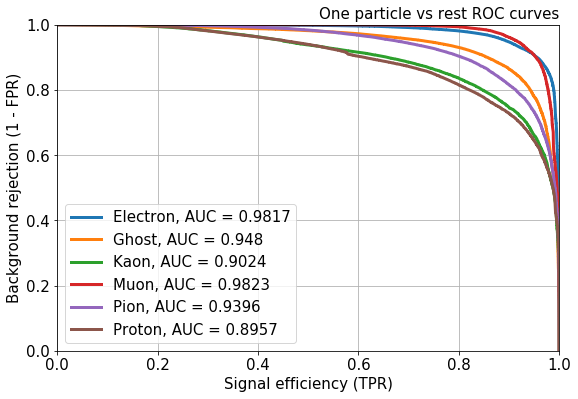

In [ ]:
roc_curves(proba_clf, valid.Class.values)

As we can see, AdaBoostClassifier performs slightly better than the neural net across the board for all particles.

In [ ]:
# release unreferenced memory to ensure we don't run out of memory
import gc
gc.collect()

7697

In [ ]:
del train, test, valid, training